# Looking into privacy policies readability

website with good visualizations https://vpnoverview.com/research/most-difficult-to-read-privacy-policies/

In [1]:
import pandas as pd
import plotly.express as px

import requests
import markdown
import plotly.graph_objects as go

In [2]:
spreadsheet_key = '1-v7zfebjdHbfFHcoNftxW7bsW1xQ2zUNvjLmH6Q4OnU'
spreadsheet_gid = '0'
csv_link = 'https://docs.google.com/spreadsheets/d/'+spreadsheet_key+'/export?gid='+spreadsheet_gid+'&format=csv'
df = pd.read_csv(csv_link)
df.sort_values(by=['Words per Sentence'], ascending=False, inplace=True)
df

,Website,Type,Reading Level,Difficulty,Words per Sentence,Overall Readability\nscore,Word count,Reading time in minutes
0,Disney+,Streaming,College Grad,Very Difficult,46.15,2.80,2573.0,19.8
1,Instagram,Social,College Grad,Very Difficult,41.44,6.20,11324.0,87.1
4,Rightmove,Housing,College Grad,Very Difficult,38.42,15.50,13675.0,105.2
2,Coral,Betting,College Grad,Very Difficult,35.77,10.10,4494.0,34.6
24,Bet365,Betting,College,Difficult,34.66,28.06,1497.0,11.5
...,...,...,...,...,...,...,...,...
79,HelloFresh,Food,College,Difficult,13.46,39.37,5383.0,41.4
100,Channel 4 (.com),Streaming,10th-12th Grade,Fairly Difficult,13.42,56.20,9285.0,71.4
101,Telegram,Messaging,10th-12th Grade,Fairly Difficult,12.93,56.70,4269.0,32.8
52,WordPress,Business,College,Difficult,12.92,32.76,1770.0,13.6


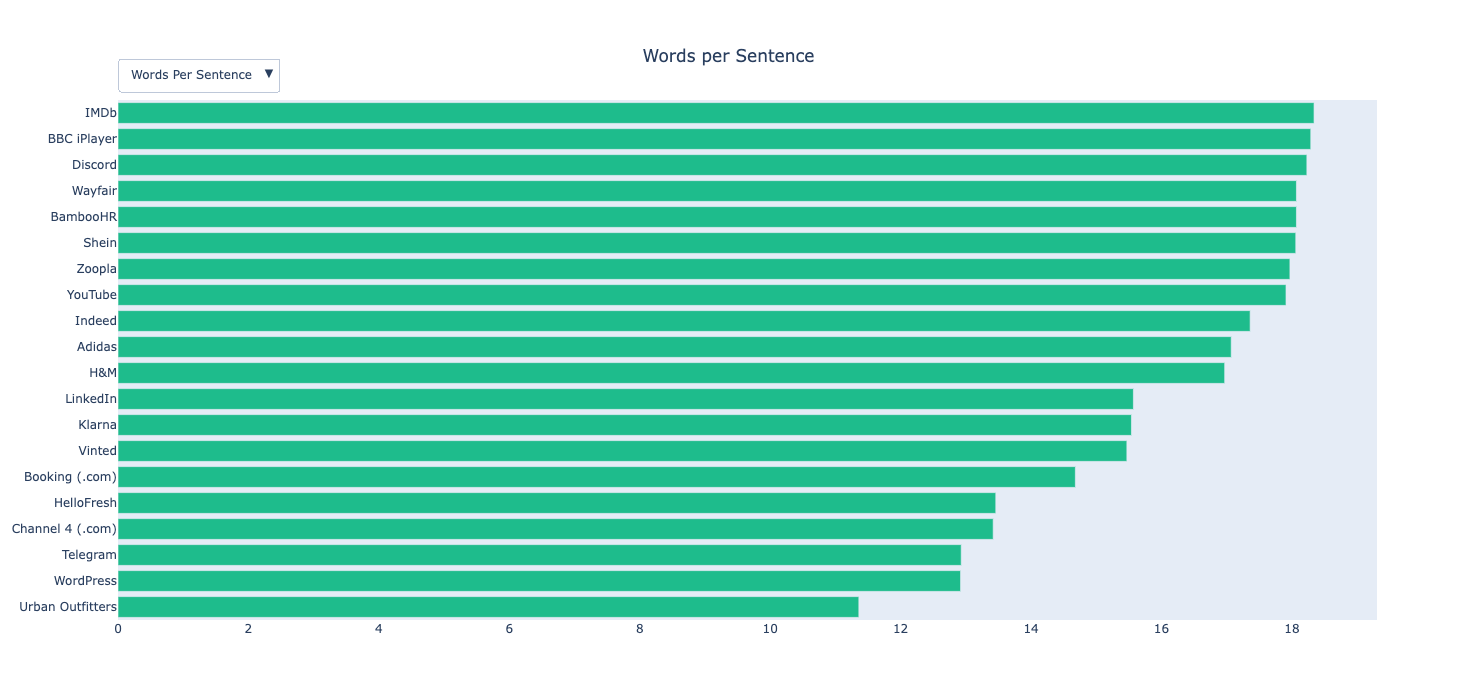

In [163]:
head_count = 20

words_per_sentence = go.Bar(y=df.sort_values(by="Words per Sentence")["Website"].head(head_count), 
                            x=df.sort_values(by="Words per Sentence")["Words per Sentence"].head(head_count), 
                            name="Words per Sentence", marker=dict(color="#1EBC8C"),
                            orientation="h", visible=True, width=0.8)
word_count = go.Bar(y=df.sort_values(by="Word count")["Website"].head(head_count), 
                    x=df.sort_values(by="Word count")["Word count"].head(head_count), 
                    name="Word Count", marker=dict(color="#7EA0BF"),
                    orientation="h", visible=False)
reading_time = go.Bar(y=df.sort_values(by="Reading time in minutes")["Website"].head(head_count), 
                      x=df.sort_values(by="Reading time in minutes")["Reading time in minutes"].head(head_count),  
                      name="Reading Time", width=0.6, marker=dict(color="#F14D78"),
                      orientation="h", visible=False)
readability_score = go.Bar(y=df.sort_values(by="Overall Readability\nscore")["Website"].head(head_count), 
                           x=df.sort_values(by="Overall Readability\nscore")["Overall Readability\nscore"].head(head_count),  
                           name="Reading Time", width=0.6, marker=dict(color="#9D7EBF"),
                           orientation="h", visible=False)

traces = [words_per_sentence, word_count, reading_time, readability_score]

fig = go.Figure(data=traces)

fig.update_layout(
    updatemenus=[
        dict(buttons=list([
            dict(label="Words Per Sentence",
                 method="update",
                 args=[{"visible": [True, False, False, False]}, 
                       {"title":{"text":"Words per Sentence", "x":0.5}}]),
            dict(label="Word Count",
                 method="update",
                 args=[{"visible": [False, True, False, False]}, 
                       {"title":{"text":"Word Count", "x":0.5}}]),
            dict(label="Reading Time",
                 method="update",
                 args=[{"visible": [False, False, True, False]}, 
                       {"title":{"text":"Reading Time", "x":0.5}}]),
            dict(label="Readability Score",
                 method="update",
                 args=[{"visible": [False, False, False, True]}, 
                       {"title":{"text":"Readability Score", "x":0.5}}]),
        ]),
             direction="down",
             pad={"r": 10, "t": 10},
             showactive=True,
             x=0,
             xanchor="left",
             y=1.1,
             yanchor="top"
            )
    ]
)

fig.update_layout(title={'text': "Words per Sentence",
                         'x':0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'},
                 height=700, width=900)

fig.show()

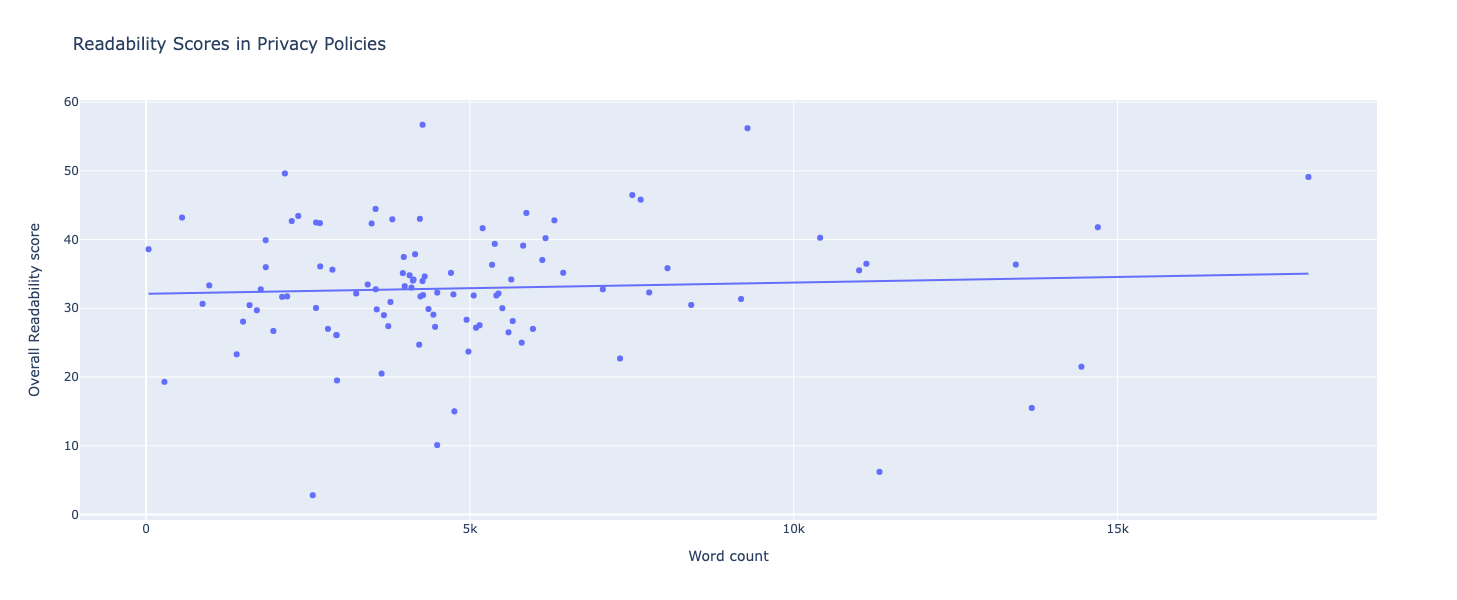

In [9]:
#df.plot.scatter(x = 'Word count', y = 'Overall Readability\nscore')
px.scatter(df, x='Word count', y='Overall Readability\nscore', title='Readability Scores in Privacy Policies', trendline='ols', height=600)

In [10]:
df['Word count'].corr(df['Overall Readability\nscore'])

0.05878532923263987

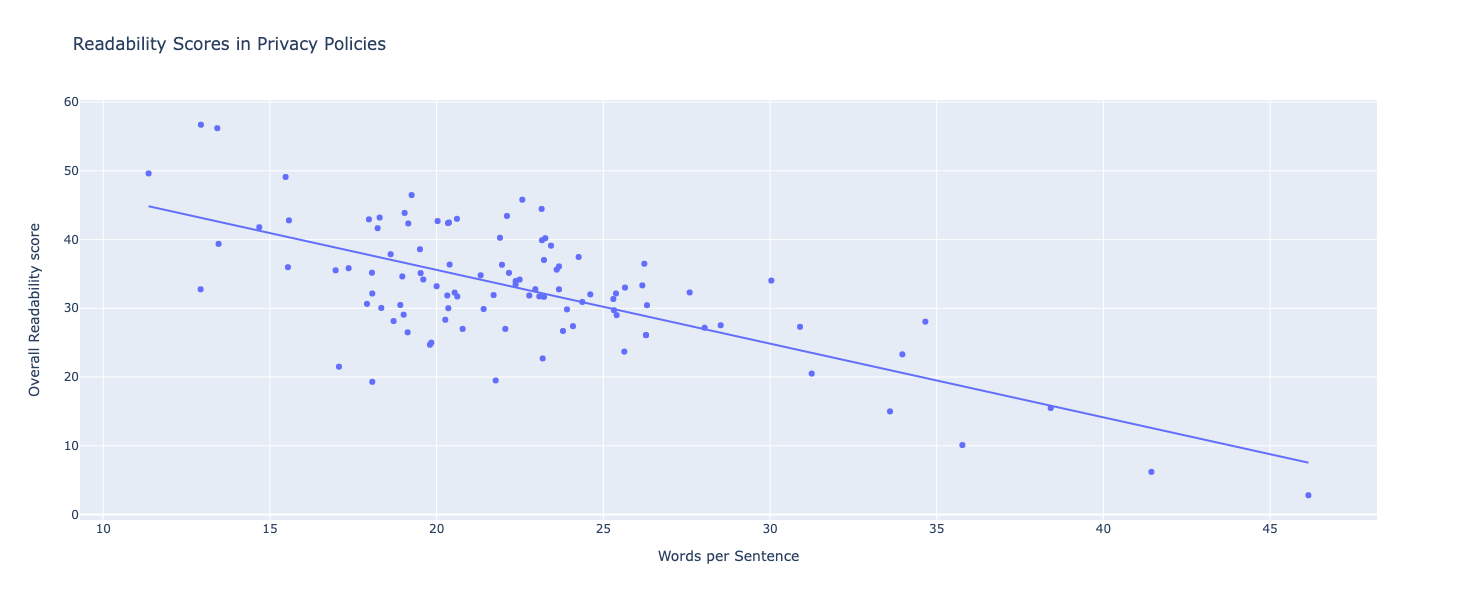

In [11]:
#df.plot.scatter(x = 'Words per Sentence', y = 'Overall Readability\nscore')
px.scatter(df, x='Words per Sentence', y='Overall Readability\nscore', title='Readability Scores in Privacy Policies', trendline='ols', height=600)

In [12]:
df['Words per Sentence'].corr(df['Overall Readability\nscore'])

-0.6873219260781296

# Doing our own analysis of privacy policies

Here is a study from Cornell University that has curated and analyzed over a million privacy policies that span over two decades.

Github repo of privacy policies they have collected: https://github.com/citp/privacy-policy-historical 

In [3]:
#!pip install --user textstat
import textstat

In [13]:
test_data = (
    "Playing games has always been thought to be important to "
    "the development of well-balanced and creative children; "
    "however, what part, if any, they should play in the lives "
    "of adults has never been researched that deeply. I believe "
    "that playing games is every bit as important for adults "
    "as for children. Not only is taking time out to play games "
    "with our children and other adults valuable to building "
    "interpersonal relationships but is also a wonderful way "
    "to release built up tension."
)

textstat.flesch_reading_ease(test_data)
textstat.flesch_kincaid_grade(test_data)
textstat.automated_readability_index(test_data)
textstat.dale_chall_readability_score(test_data)
textstat.difficult_words(test_data)
textstat.linsear_write_formula(test_data)
textstat.gunning_fog(test_data)

12.38

Let's investigate the privacy policies of the most popular social media websites accoriding to [statista.com](https://www.statista.com/statistics/272014/global-social-networks-ranked-by-number-of-users/). We will specifically look at YouTube, Twitter, Instagram, Facebook, TikTok, and Pinterest

### Jenny 

In [4]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import re 

In [5]:
def search_for_site(keyword):
    
    base_url = "https://github.com/citp/privacy-policy-historical/tree/master/"
    first_letter = keyword[0]
    second_letter = keyword[0:2]
    third_letter = keyword[0:3]
    
    search_url = base_url + first_letter + "/" + second_letter + "/" + third_letter
    r = requests.get(search_url)
    soup = BeautifulSoup(r.text)
    mydivs = soup.find_all("a", {"class": "js-navigation-open Link--primary"})
    
    title_list = []
    for item in mydivs:
        title_list.append(item.get("title"))
        
    result_list = []
    for website in title_list:
        if keyword in website:
            result_list.append(website)
            
    if not result_list:
        print("No website")
        
    if len(result_list) == 1:
        return result_list
    
    if len(result_list) > 1:
        print(result_list)
        
        
search_for_site("google")

['google-adsense-templates.co.uk.md', 'google-analytics.com.md', 'google-custom.com.md', 'google-developers.appspot.com.md', 'google-latlong.blogspot.com.md', 'google-melange.com.md', 'google-mkto.com.md', 'google-opensource.blogspot.com.md', 'google-pagerank.net.md', 'google-store.com.md', 'google.ac.md', 'google.as.md', 'google.at.md', 'google.bs.md', 'google.ca.md', 'google.co.ao.md', 'google.co.bw.md', 'google.co.hu.md', 'google.co.in.md', 'google.co.jp.md', 'google.co.ke.md', 'google.co.ls.md', 'google.co.md', 'google.co.nz.md', 'google.co.ug.md', 'google.co.uk.md', 'google.co.vi.md', 'google.co.za.md', 'google.co.zm.md', 'google.co.zw.md', 'google.com.ag.md', 'google.com.ai.md', 'google.com.au.md', 'google.com.bz.md', 'google.com.cy.md', 'google.com.fj.md', 'google.com.gh.md', 'google.com.gi.md', 'google.com.iq.md', 'google.com.jm.md', 'google.com.md', 'google.com.my.md', 'google.com.na.md', 'google.com.ng.md', 'google.com.pg.md', 'google.com.ph.md', 'google.com.pk.md', 'google.c

In [7]:
policies = ['https://github.com/citp/privacy-policy-historical/blob/master/t/ti/tik/tiktok.com.md',
            'https://github.com/citp/privacy-policy-historical/blob/master/t/tw/twi/twitter.com.br.md',
           'https://github.com/citp/privacy-policy-historical/blob/master/f/fa/fac/facebook.com.md',
           'https://github.com/citp/privacy-policy-historical/blob/master/i/in/ins/instagram.com.md',
           'https://github.com/citp/privacy-policy-historical/blob/master/y/yo/you/youtube.com.md',
           'https://github.com/citp/privacy-policy-historical/blob/master/p/pi/pin/pinterest.com.md']

In [81]:
def create_df(alist: list):
    result_dict = {}
    title_list = ['Tiktok', 'Twitter', 'Facebook', 'Instagram', 'Youtube','Pinterest']
    
    for i, url in enumerate(policies): 

        response = requests.get(url)

        content = response.text

        start_index = content.find('<article')
        end_index = content.find('</article>')

        body_content = content[start_index:end_index]

        html = markdown.markdown(body_content)
        soup = BeautifulSoup(html, 'html.parser')
        texts = soup.get_text()
        result_dict[title_list[i]] = texts

    df = pd.DataFrame(result_dict.items(), columns=["Social_Media", "Texts"])
    remove_n = lambda x: x.replace('\n', '')
    df["Texts"] = df["Texts"].apply(remove_n)
    return df

policy_df = create_df(policies)
policy_df

,Social_Media,Texts
0,Tiktok,The following text is extracted and transforme...
1,Twitter,The following text is extracted and transforme...
2,Facebook,The following text is extracted and transforme...
3,Instagram,The following text is extracted and transforme...
4,Youtube,The following text is extracted and transforme...
5,Pinterest,The following text is extracted and transforme...


In [16]:
readability_score = lambda x: textstat.dale_chall_readability_score(x)
grade_score = lambda x: textstat.flesch_kincaid_grade(x)
reading_time = lambda x: textstat.reading_time(x, ms_per_char=14.69)
policy_df["Readability_score"] = policy_df["Texts"].apply(readability_score)
policy_df["Grade_score"] = policy_df["Texts"].apply(grade_score)
policy_df["Reading_time"] = policy_df["Texts"].apply(reading_time)
policy_df

,Social_Media,Texts,Readability_score,Grade_score,Reading_time
0,Tiktok,The following text is extracted and transforme...,7.82,14.6,222.04
1,Twitter,The following text is extracted and transforme...,7.22,14.2,374.86
2,Facebook,The following text is extracted and transforme...,6.94,12.9,319.38
3,Instagram,The following text is extracted and transforme...,7.34,14.0,233.23
4,Youtube,The following text is extracted and transforme...,7.47,12.9,223.82
5,Pinterest,The following text is extracted and transforme...,6.58,10.8,276.58


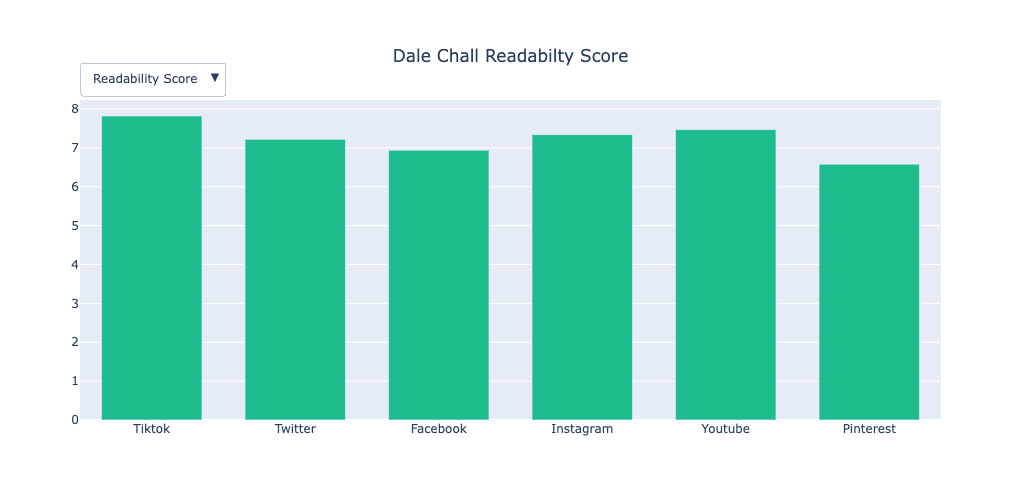

In [79]:
readability_trace = go.Bar(x=policy_df["Social_Media"], y=policy_df["Readability_score"], width=0.7,
                           name="Readability Score", marker=dict(color="#1EBC8C"), visible=True)
grade_trace = go.Bar(x=policy_df["Social_Media"], y=policy_df["Grade_score"], 
                     name="Grade Score", width=0.7, marker=dict(color="#4D8AF1"), visible=False)
time_trace = go.Bar(x=policy_df["Social_Media"], y=policy_df["Reading_time"], 
                    name="Reading Time", width=0.7, marker=dict(color="#F14D78"), visible=False)
traces = [readability_trace, grade_trace, time_trace]

fig = go.Figure(data=traces)

fig.update_layout(
    updatemenus=[
        dict(buttons=list([
            dict(label="Readability Score",
                 method="update",
                 args=[{"visible": [True, False, False]}, 
                       {"title":{"text":"Dale Chall Readabilty Score", "x":0.5}}]),
            dict(label="Grade Trace",
                 method="update",
                 args=[{"visible": [False, True, False]}, 
                       {"title":{"text":"Flesch Kincaid Reading Grade", "x":0.5}}]),
            dict(label="Reading Time",
                 method="update",
                 args=[{"visible": [False, False, True]}, 
                       {"title":{"text":"Reading Time", "x":0.5}}]),
        ]),
             direction="down",
             pad={"r": 10, "t": 10},
             showactive=True,
             x=0,
             xanchor="left",
             y=1.15,
             yanchor="top"
            )
    ]  
)

fig.update_layout(
    title={'text': "Dale Chall Readabilty Score",
           'x':0.5,
           'xanchor': 'center',
           'yanchor': 'top'},
    height=500, width=700)

fig.show()

## Web Scraping

Below is an exmaple of web scarping on Google privacy policy.

In [59]:
def webscrape_private_policy(url):
    search_url = url

    r = requests.get(search_url)
    soup = BeautifulSoup(r.text)
    mydivs = soup.find_all("div", {"class": "nrAB0c"})
    contents_list = []
    for item in mydivs:
        contents_list.append(item.find("p"))
        contents_list.append(item.find("ul"))

    cleaned_contents_list = []
    for ind, content in enumerate(contents_list):
        content = str(content)
        if content != "None":
            content = re.sub('<.*?>', '', content)
            cleaned_contents_list.append(content)
        if content == "None":
            continue
            
    cleaned_text = ''.join([content for content in cleaned_contents_list])
    return cleaned_text

url = "https://policies.google.com/privacy?hl=en-US"
webscrape_private_policy(url)

"When you use our services, you’re trusting us with your information. We understand this is a big responsibility and work hard to protect your information and put you in control.We build a range of services that help millions of people daily to explore and interact with the world in new ways. Our services include:Google apps, sites, and devices, like Search, YouTube, and Google HomePlatforms like the Chrome browser and Android operating systemProducts that are integrated into third-party apps and sites, like ads, analytics, and embedded Google MapsWe want you to understand the types of information we collect as you use our servicesTerms you search forVideos you watchViews and interactions with content and adsVoice and audio informationPurchase activityPeople with whom you communicate or share contentActivity on third-party sites and apps that use our servicesChrome browsing history you’ve synced with your Google AccountWe use data to build better servicesWe don’t show you personalized 